In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=62c399dbc43606d8828aabcd2bcf8c59a096c22cf6c7137ccf97f446ae91276a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# create spark context and spark session
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("MIS584_Lab_Assignment2")
#sc = SparkContext(conf = conf)

# Get or create a SparkContext
sc = SparkContext.getOrCreate()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MIS584_Lab_Assignment2").getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from pyspark.sql.functions import col, length, sum
from pyspark.sql.functions import round
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings



# Initialize a SparkSession
spark = SparkSession.builder \
    .appName("Read CSV and Show Schema") \
    .getOrCreate()


# Define the path to the CSV files
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/sales receipts.csv"
csv_file_path1 = "/content/drive/MyDrive/Colab Notebooks/product.csv"
csv_file_path2 = "/content/drive/MyDrive/Colab Notebooks/sales_outlet.csv"

# Use the read.csv function to read the CSV into a DataFrame
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
df1 = spark.read.csv(csv_file_path1, header=True, inferSchema=True)
df2 = spark.read.csv(csv_file_path2, header=True, inferSchema=True)


# Print the schema of the DataFrame
df.printSchema()
df1.printSchema()
df2.printSchema()

df.show(5);
df1.show(5);
df2.show(5);


# Check for missing values in the entire DataFrame
missing_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts_1 = df1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns])
missing_counts_2 = df2.select([sum(col(c).isNull().cast("int")).alias(c) for c in df2.columns])

# Display the missing value counts for each column
missing_counts.show()
missing_counts_1.show()
missing_counts_2.show()


df.createOrReplaceTempView("df")
df1.createOrReplaceTempView("df1")

# Run the SQL query joining the sales receipts table to the product table
result = spark.sql("""
    SELECT df.sales_outlet_id, df.product_id, SUM(df.line_item_amount) AS TotalSales FROM df INNER JOIN  df AS df1 ON df.product_id = df1.product_id GROUP BY
    df.sales_outlet_id, df.product_id ORDER BY df.sales_outlet_id;
""")

# Show the result
result.show()

resultant_table = result.join(df1, on=['product_id'], how='inner')

resultant_table.show()


final_table = resultant_table.join(df2, on=['sales_outlet_id'], how='inner')
final_table.show()

output_path = "/content/drive/MyDrive/finalcsv"

# Use the DataFrame write method to export to CSV
final_table.write.csv(output_path, header=True, mode="overwrite")







root
 |-- transaction_id: integer (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- transaction_time: timestamp (nullable = true)
 |-- sales_outlet_id: integer (nullable = true)
 |-- staff_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- instore_yn: string (nullable = true)
 |-- order: integer (nullable = true)
 |-- line_item_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- line_item_amount: double (nullable = true)
 |-- unit_price: double (nullable = true)
 |-- promo_item_yn: string (nullable = true)

root
 |-- product_id: integer (nullable = true)
 |-- product_group: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product_type: string (nullable = true)
 |-- product: string (nullable = true)
 |-- product_description: string (nullable = true)
 |-- unit_of_measure: string (nullable = true)
 |-- current_wholesale_price: double (nullable = tr

### The results above show that all three datasets do not have null or missing values except for the manager column in the sales outlet dataset with 1 missing value

### All three datasets are now joined and the final dataset is what we will work with

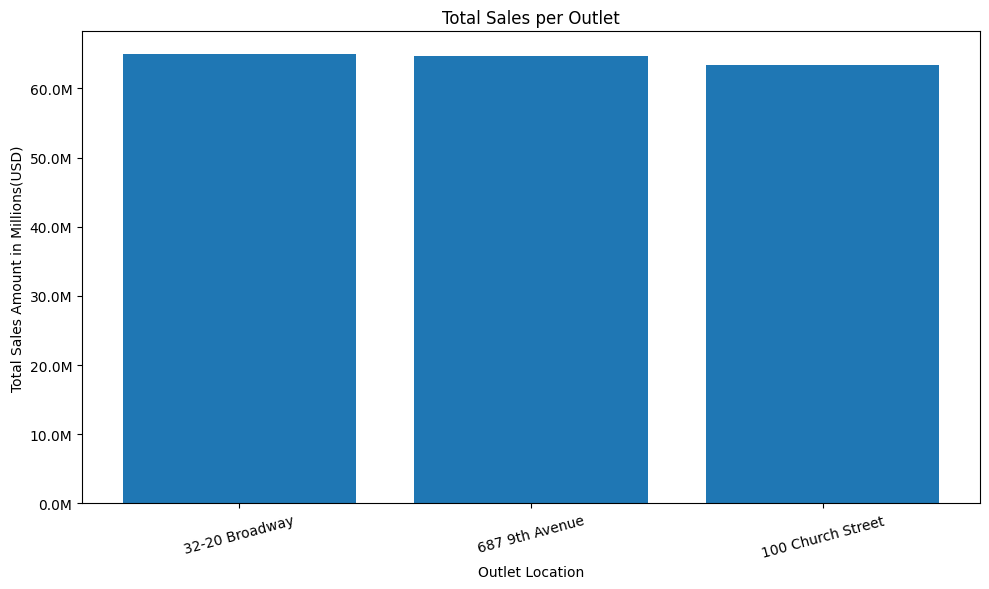

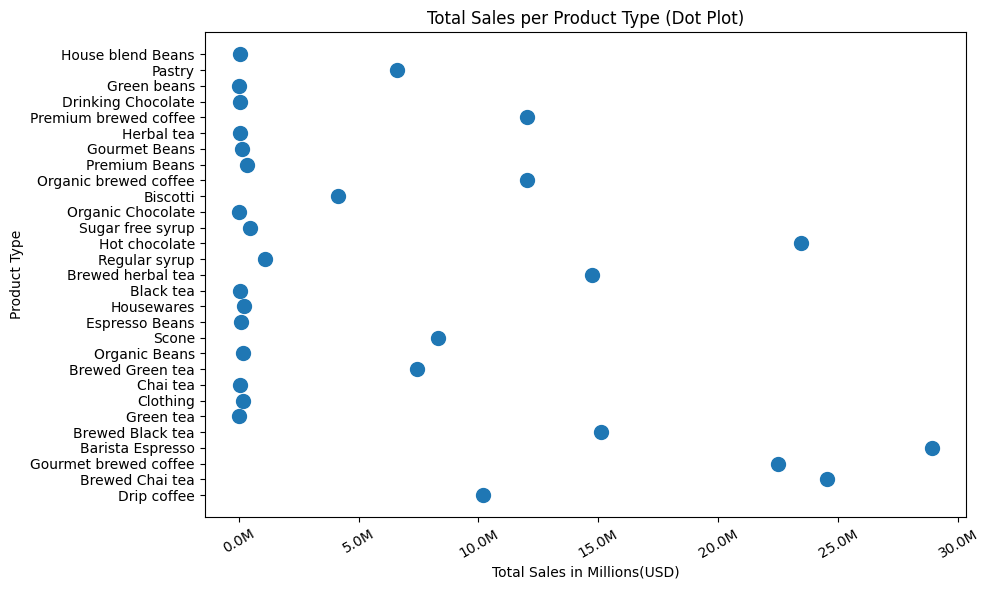

<ipython-input-14-5e8507982eab>:51: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  coffee_corr_matrix = pandas_df.corr()


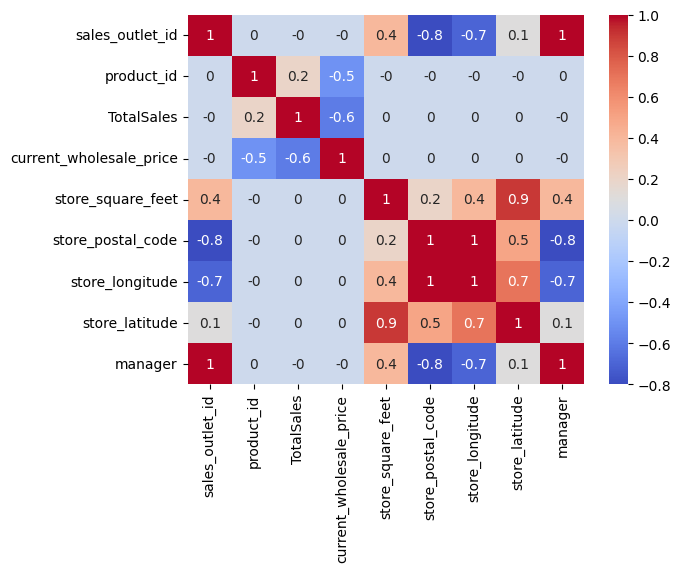

<Figure size 1000x600 with 0 Axes>

In [ ]:


#Use the rdd property to convert your DataFrame into an RDD.
#Then,use the reduceByKey transformation to calculate the total sales per outlet:
rdd = final_table.rdd.map(lambda x: (x['store_address'], x['TotalSales']))
totals = rdd.reduceByKey(lambda a, b: a + b).collect()

#Convert the results to a Pandas DataFrame for plotting:
totals_df = pd.DataFrame(totals, columns=['store_address', 'TotalSales'])

def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

#plot the results
plt.figure(figsize=(10, 6))
plt.bar(totals_df['store_address'], totals_df['TotalSales'])
plt.xlabel('Outlet Location')
plt.ylabel('Total Sales Amount in Millions(USD)')
plt.title('Total Sales per Outlet')
plt.xticks(rotation = 15)
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))  # Apply the formatter
plt.tight_layout()
plt.show()

# Convert DataFrame to RDD, where each element is a tuple of (product_type, total_sales)
rdd1 = final_table.rdd.map(lambda x: (x['product_type'], x['TotalSales'])).reduceByKey(lambda a, b: a + b)

# Collect the results
results = rdd1.collect()

# Extract data for plotting
product_types = [result[0] for result in results]
total_sales = [result[1] for result in results]

# Create the dot plot
plt.figure(figsize=(10, 6))
plt.plot(total_sales, product_types, 'o', markersize=10)
plt.xlabel('Total Sales in Millions(USD)')
plt.ylabel('Product Type')
plt.title('Total Sales per Product Type (Dot Plot)')
plt.xticks(rotation = 30)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions_formatter))  # Apply the formatter

# Show the plot
plt.tight_layout()
plt.show()

#convert spark dataframe to pandas dataframe
pandas_df = final_table.toPandas()

# Compute the correlation matrix of the variables
coffee_corr_matrix = pandas_df.corr()

# Round off values to one decimal place using NumPy
rounded_matrix = np.round(coffee_corr_matrix, 1)

# Print the rounded matrix
#print(rounded_matrix)


# Create the heatmap using the `heatmap` function of Seaborn
sns.heatmap(rounded_matrix, cmap='coolwarm', annot=True)

# Display the heatmap using the `show` method of the `pyplot` module from matplotlib.
plt.figure(figsize=(10, 6))
plt.show()





# Stop the spark session
spark.stop()






